In [3]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

memory = MemorySaver()

search_tool = TavilySearch(max_results=2, topic="general")
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

class BasicState(TypedDict): 
    messages: Annotated[List, add_messages]

def model(state: BasicState): 
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state: BasicState): 
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return END


graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router)

graph.add_edge("tools", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

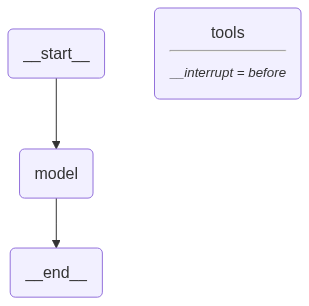

In [3]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [33]:
config = {"configurable": {
    "thread_id": 1
}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Chennai?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in Chennai?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (tbk81t76z)
 Call ID: tbk81t76z
  Args:
    query: Current weather in Chennai time now
    topic: news


In [32]:
snapshot = app.get_state(config=config)
snapshot.next

()

In [34]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search (tbk81t76z)
 Call ID: tbk81t76z
  Args:
    query: Current weather in Chennai time now
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "Current weather in Chennai time now", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in Chennai", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Chennai', 'region': 'Tamil Nadu', 'country': 'India', 'lat': 13.0833, 'lon': 80.2833, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1753809399, 'localtime': '2025-07-29 22:46'}, 'current': {'last_updated_epoch': 1753809300, 'last_updated': '2025-07-29 22:45', 'temp_c': 32.4, 'temp_f': 90.3, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 14.3, 'wind_kph': 23.0, 'wind_de